# Regridding WW3 using weighting matrix

### Using weighting matrix at /ocean/abhudia/MEOPAR/analysis-ashutosh/scripts/ww3_weighting_matrix_hake.nc generated using /ocean/abhudia/MEOPAR/analysis-ashutosh/scruipts/run_interp.py to perform regridding from WW3 to SSC for MOHID

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import viz_tools
%matplotlib inline

In [2]:
def interpolate(ww3array):
    whitecap_arr = np.transpose(ww3array,[1,2,0])
    weighting = xr.open_dataset('scripts/ww3_weighting_matrix_hake.nc')
    #weights and y,x indices to use from source grid
    weights, y, x = weighting.weights.values, weighting.y.values.astype(int), weighting.x.values.astype(int)
    new_grid = np.zeros([898,398, 48])
    # fill with nanas so we maintain mask
    new_grid[:,:,:]=np.nan
    # do the inteprolation
    for i in range(898):
        for j in range(398):
            y_ind, x_ind, w = y[i][j], x[i][j], weights[i][j]
            y1,y2,y3,y4 = y_ind
            x1,x2,x3,x4 = x_ind
            w1,w2,w3,w4 = w
            if y1 == -9223372036854775808:
                s1 = False
            else:
                try:
                    s1 = whitecap_arr[y1][x1]*w1
                except IndexError:
                    print(w1,x1,y1)
            if y2 == -9223372036854775808:
                s2 = False
            else:
                s2 = whitecap_arr[y2][x2]*w2
            if y3 == -9223372036854775808:
                s3 = False
            else:
                s3 = whitecap_arr[y3][x3]*w3
            if y4 == -9223372036854775808:
                s4 = False
            else:
                s4 = whitecap_arr[y4][x4]*w4
            array = []
            for element in (s1,s2,s3,s4):
                if type(element) is bool:
                    pass
                else:
                    array.append(element)
            if len(array) == 0:
                continue
            else:
                array = np.asarray(array)
                nansum = np.nansum(array,axis = 0)
                new_grid[i][j] = nansum
    new_grid = np.transpose(new_grid, [2,0,1])
    return new_grid

In [3]:
ww3 = xr.open_dataset('/opp/wwatch3/nowcast/13apr18/SoG_ww3_fields_20180413_20180413.nc')
ww3array = ww3.wcc.values
interp = interpolate(ww3array)

In [8]:
# beats out the > 370s it takes scipy.griddata to process 24 hrs of ww3 output. Performance should remain the same even for lerger arrays.
%%timeit
interpolate(ww3array)

3.02 s ± 47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/abhudia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


Text(0.5, 0.89, 'Comparing interpolated grid slices. Original from ww3 on left, My interplation onto SSC grid on right. Pacific has been masked out from ww3 grid.')

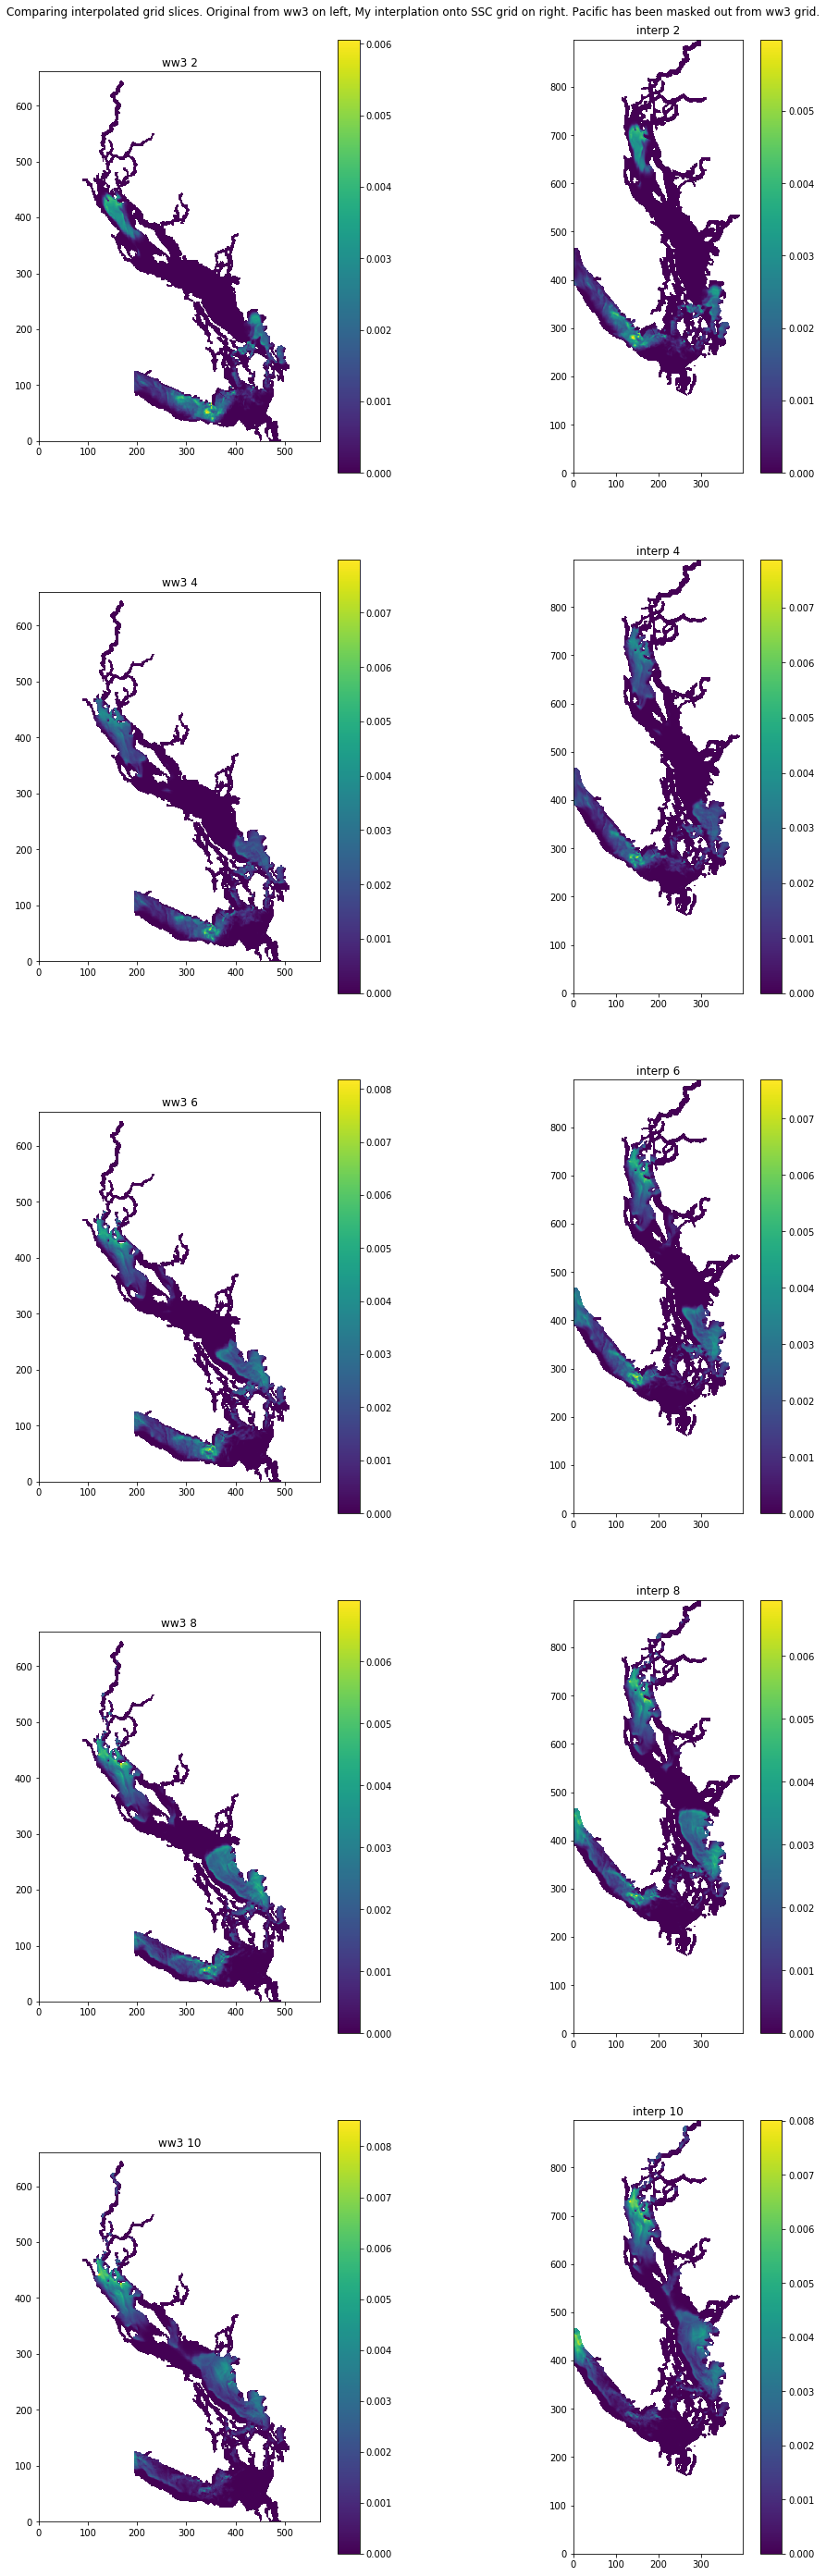

In [4]:
# mask out the pacific
ww3array[:,0:300,0:195] = np.nan
fig = plt.figure(figsize=(15,50))
for i in range(1,6):
    ax = plt.subplot(5,2, 2*i -1)
    plt.pcolormesh(ww3array[2*i])
    plt.title(f'ww3 {2*i}')
    viz_tools.set_aspect(ax)
    plt.colorbar()
    
    ax1 = plt.subplot(5,2, 2*i)
    plt.pcolormesh(interp[2*i])
    plt.title(f'interp {2*i}')
    viz_tools.set_aspect(ax1)
    plt.colorbar()
plt.suptitle('Comparing interpolated grid slices. Original from ww3 on left, My interplation onto SSC grid on right. Pacific has been masked out from ww3 grid.'
             ,y = 0.89)